In [23]:

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import wandb

In [24]:
class PolygonColoringDataset(Dataset):
    def __init__(self, root_dir, split="training", color_list=None, image_size=(128, 128)):
        self.root_dir = os.path.join(root_dir, split)
        self.image_size = image_size

        json_path = os.path.join(self.root_dir, "C:/Users/User/Downloads/dataset/dataset/training/data.json")
        with open(json_path, "r") as f:
            self.data = json.load(f)

        if color_list is None:
            self.color_list = sorted(list({item["color"] for item in self.data}))
        else:
            self.color_list = color_list
        self.color2idx = {color: idx for idx, color in enumerate(self.color_list)}

        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_path = os.path.join(self.root_dir, item["input_polygon"])
        output_path = os.path.join(self.root_dir, item["output_image"])
        color_name = item["colour"]

        input_img = Image.open(input_path).convert("L")
        output_img = Image.open(output_path).convert("RGB")

        input_tensor = self.transform(input_img)
        output_tensor = self.transform(output_img)

        color_index = self.color2idx[color_name]
        color_onehot = torch.zeros(len(self.color_list))
        color_onehot[color_index] = 1.0

        return {
            "input_image": input_tensor,
            "color_onehot": color_onehot,
            "target_image": output_tensor,
            "color_name": color_name
        }

In [25]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [26]:
class UNet(nn.Module):
    def __init__(self, input_channels=1, num_classes=3, num_colors=5):
        super().__init__()
        self.embedding_size = 64
        self.color_embedding = nn.Sequential(
            nn.Linear(num_colors, self.embedding_size),
            nn.ReLU(),
            nn.Linear(self.embedding_size, input_channels * 128 * 128)
        )

        self.inc = DoubleConv(input_channels + 1, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.bottleneck = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, num_classes, 1)

    def forward(self, x, color_onehot):
        B, C, H, W = x.shape
        color_embed = self.color_embedding(color_onehot).view(B, 1, H, W)
        x = torch.cat([x, color_embed], dim=1)

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.bottleneck(x4)

        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x4], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x3], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x2], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x1], dim=1))
        return self.outc(x)

In [30]:
wandb.init(project="polygon-coloring-unet")

color_list = ['red', 'blue', 'green', 'yellow', 'purple', 'cyan', 'orange', 'magenta'] 
train_ds = PolygonColoringDataset("dataset", split="training", color_list=color_list)
val_ds = PolygonColoringDataset("dataset", split="validation", color_list=color_list)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

model = UNet(num_colors=len(color_list))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inp = batch['input_image']
        target = batch['target_image']
        color = batch['color_onehot']

        out = model(inp, color)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    wandb.log({"train_loss": total_loss / len(train_loader)})
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.8951
Epoch 2, Loss: 0.7093
Epoch 3, Loss: 0.5749
Epoch 4, Loss: 0.4720
Epoch 5, Loss: 0.3933
Epoch 6, Loss: 0.3296
Epoch 7, Loss: 0.2806
Epoch 8, Loss: 0.2444
Epoch 9, Loss: 0.2167
Epoch 10, Loss: 0.1949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


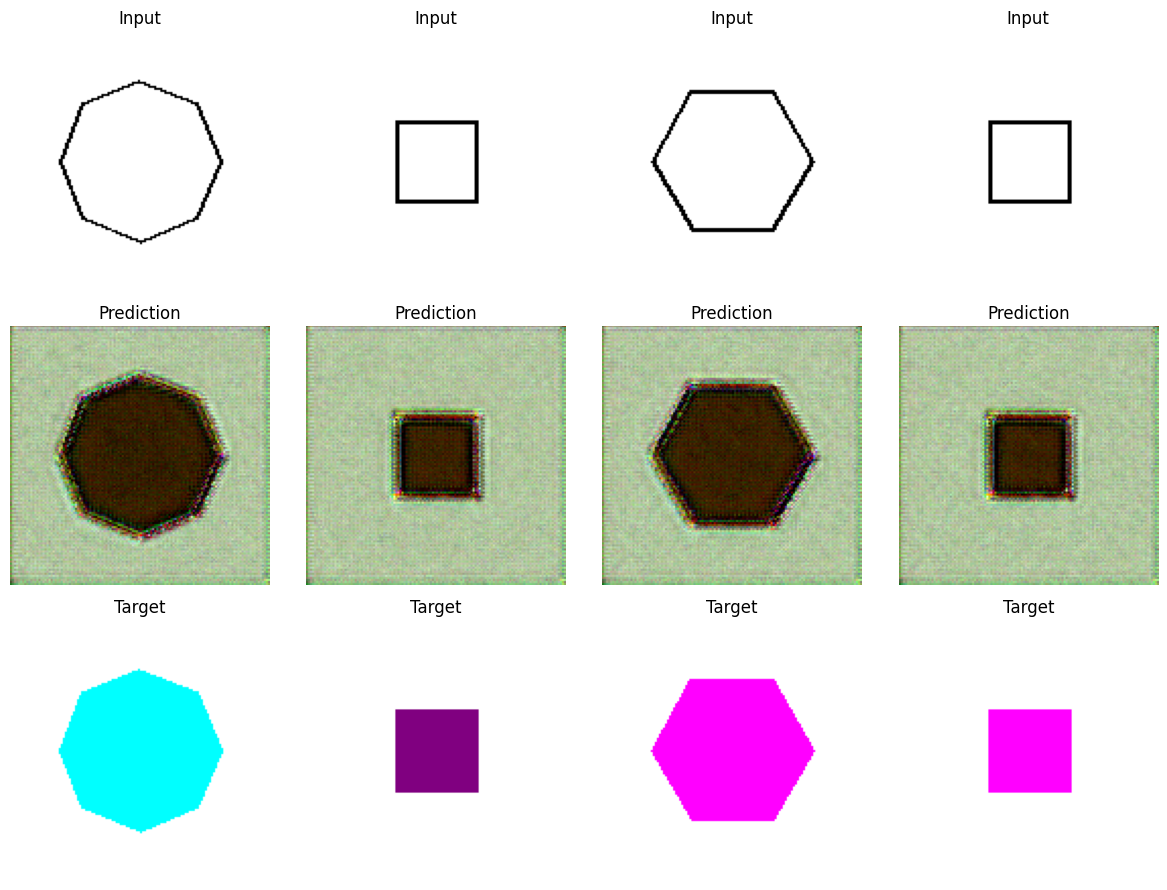

In [31]:
import random
model.eval()
batch = next(iter(val_loader))
inputs = batch['input_image']
colors = batch['color_onehot']
targets = batch['target_image']

with torch.no_grad():
    preds = model(inputs, colors)


fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(4):
    axs[0, i].imshow(inputs[i][0].cpu(), cmap='gray')
    axs[0, i].set_title("Input")
    axs[1, i].imshow(preds[i].permute(1, 2, 0).cpu())
    axs[1, i].set_title("Prediction")
    axs[2, i].imshow(targets[i].permute(1, 2, 0).cpu())
    axs[2, i].set_title("Target")
    for row in range(3):
        axs[row, i].axis('off')
plt.tight_layout()
plt.show()
